<a href="https://colab.research.google.com/github/lahirumanulanka/ann-visual-emotion/blob/created_gen_ai_imagers/notebooks/CNN_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone -b created_gen_ai_imagers https://github.com/lahirumanulanka/ann-visual-emotion

Cloning into 'ann-visual-emotion'...
remote: Enumerating objects: 385463, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 385463 (delta 110), reused 99 (delta 97), pack-reused 385330 (from 3)
Receiving objects: 100% (385463/385463), 4.74 GiB | 16.67 MiB/s, done.
Resolving deltas: 100% (54161/54161), done.
Updating files: 100% (251101/251101), done.


# Emotion Classification with Advanced Transfer Learning

## Overview
This comprehensive notebook implements state-of-the-art deep learning techniques for visual emotion recognition using transfer learning. Our approach combines multiple advanced strategies to achieve superior performance:

### Key Features & Improvements:

#### **Two-Stage Progressive Fine-tuning**
- **Stage 1**: Head-only warmup training (freeze backbone features)
- **Stage 2**: Full model fine-tuning with discriminative learning rates
- Prevents catastrophic forgetting while enabling feature adaptation

#### **Advanced Training Techniques**
- **Smart Learning Rate Scheduling**: Linear warmup followed by cosine decay
- **Mixed Precision Training**: Faster training with automatic loss scaling
- **Exponential Moving Average (EMA)**: Stabilized model weights for better generalization
- **Early Stopping**: Prevents overfitting with patience-based monitoring

#### **Comprehensive Evaluation & Monitoring**
- Real-time training metrics: Loss, Accuracy, Macro F1-Score
- Learning rate tracking for each parameter group
- Detailed confusion matrices and classification reports
- Cross-validation on validation and test sets

#### **Model Explainability & Interpretability**
- **Grad-CAM & Grad-CAM++**: Visual attention heatmaps
- **SHAP (Deep Explainer)**: Feature importance analysis
- **LIME**: Local interpretable model explanations

#### **Production-Ready Features**
- ONNX model export for deployment
- Safe checkpoint handling (PyTorch 2.6+ compatible)
- Comprehensive logging and reproducibility

### Configuration Tips:
- **Data Paths**: Ensure CSV file paths are correctly set in configuration
- **Hardware**: Increase `batch_size` for larger GPUs (recommended: 32-64)
- **Model Selection**: Choose from ResNet50, ConvNeXt, EfficientNet, or Vision Transformers
- **Hyperparameters**: Tune learning rates based on your dataset size and complexity


In [2]:
# Package Installation & Dependencies
# Installing essential libraries for advanced deep learning and model explainability
# Uncomment the line below if running on a fresh Colab environment

print("Installing required packages for advanced emotion recognition...")
print("Package overview:")
print("- timm: State-of-the-art computer vision models")
print("- grad-cam: Gradient-based model visualization")
print("- shap: SHapley Additive exPlanations for ML interpretability")
print("- lime: Local Interpretable Model-agnostic Explanations")
print("- onnx: Open Neural Network Exchange format")
print("- onnxruntime: High-performance inference engine")
print("- opencv-python: Computer vision utilities")
print("- seaborn: Statistical data visualization")
print("- scikit-learn: Machine learning metrics and utilities")

%pip install -U timm grad-cam shap lime onnx onnxruntime opencv-python seaborn scikit-learn

print("Package installation completed!")

Installing required packages for advanced emotion recognition...
Package overview:
- timm: State-of-the-art computer vision models
- grad-cam: Gradient-based model visualization
- shap: SHapley Additive exPlanations for ML interpretability
- lime: Local Interpretable Model-agnostic Explanations
- onnx: Open Neural Network Exchange format
- onnxruntime: High-performance inference engine
- opencv-python: Computer vision utilities
- seaborn: Statistical data visualization
- scikit-learn: Machine learning metrics and utilities
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 

In [3]:
# Comprehensive Library Imports & Setup
print("Initializing advanced emotion recognition framework...")
print("Loading essential libraries for deep learning and model explainability")

# Core Python libraries for data handling and utilities
from __future__ import annotations
import os, gc, json, math, time, random, pathlib
from pathlib import Path
from dataclasses import dataclass, asdict
from typing import Optional, List, Dict, Tuple

# Data manipulation and numerical computing
import numpy as np
import pandas as pd
from PIL import Image

# PyTorch deep learning framework
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

# Computer vision and pre-trained models
from torchvision import transforms, models

# Machine learning evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Advanced model architectures (optional but recommended)
try:
    import timm
    TIMM_AVAILABLE = True
    print("TIMM library available - access to 900+ pre-trained models")
except Exception:
    TIMM_AVAILABLE = False
    print("TIMM library not available - using standard torchvision models only")

# Model explainability and interpretability tools
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
import shap
from lime import lime_image

# Model export and deployment utilities
import onnx, onnxruntime as ort
import cv2

print("All libraries successfully imported!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Initializing advanced emotion recognition framework...
Loading essential libraries for deep learning and model explainability
TIMM library available - access to 900+ pre-trained models
All libraries successfully imported!
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU device: Tesla T4
GPU memory: 15.8 GB


## **Advanced Configuration & Hyperparameters**

This comprehensive configuration system allows fine-tuning of all aspects of the training process. Each parameter is carefully selected based on best practices and empirical research.

### **Data Configuration**
- **CSV Paths**: Update paths below to point to your training, validation, and test CSV files
- **Label Mapping**: JSON file containing emotion class mappings
- **Output Directory**: Where models, logs, and artifacts will be saved

### **Model Architecture Selection**
- **`model_type`**: Choose from powerful pre-trained architectures:
  - `'resnet50'`: Robust residual network (default, well-tested)
  - `'convnext_base'`: Modern ConvNet with Transformer-inspired design
  - `'tf_efficientnet_b3_ns'`: Efficient scaling with noise-robustness
  - `'vit_base_patch16_224'`: Vision Transformer for attention-based learning
- **`pretrained`**: Use ImageNet pre-trained weights (highly recommended)
- **`img_size`**: Input image resolution (224x224 is standard)

### **Progressive Training Strategy**
- **`freeze_backbone_epochs`**: Number of warmup epochs with frozen backbone
  - Prevents catastrophic forgetting of pre-trained features
  - Allows classifier head to learn optimal mappings first
- **Discriminative Learning Rates**: Different rates for backbone vs. head

In [4]:
@dataclass
class CFG:
    # Paths (update as needed)
    project_root: Path = Path('/content/ann-visual-emotion')
    csv_train: Path = Path('/content/ann-visual-emotion/data/processed/EmoSet_splits_gen/train.csv')
    csv_val:   Path = Path('/content/ann-visual-emotion/data/processed/EmoSet_splits_gen/val.csv')
    csv_test:  Path = Path('/content/ann-visual-emotion/data/processed/EmoSet_splits_gen/test.csv')
    label_map_json: Path = Path('/content/ann-visual-emotion/data/processed/EmoSet_splits_gen/label_map.json')
    out_dir: Path = Path('/content/ann-visual-emotion/models')

    image_col: str = 'path'
    label_col: str = 'label'

    # Backbone
    model_type: str = 'resnet50'  # try: 'convnext_base', 'tf_efficientnet_b3_ns', 'vit_base_patch16_224'
    pretrained: bool = True
    img_size: int = 224

    # Optimization
    batch_size: int = 32
    epochs: int = 80
    freeze_backbone_epochs: int = 3  # head-only warmup
    lr_backbone: float = 1e-4
    lr_head: float = 1e-3
    weight_decay: float = 1e-4
    label_smoothing: float = 0.05
    use_amp: bool = True
    grad_clip_norm: float = 1.0

    # Regularization
    use_mixup: bool = True
    mixup_alpha: float = 0.4
    use_cutmix: bool = False
    cutmix_alpha: float = 1.0

    # Early stopping
    patience: int = 5
    monitor: str = 'macro_f1'  # or 'acc'

    # EMA
    use_ema: bool = True
    ema_decay: float = 0.999

    # Class weighting / sampler
    use_class_weights: bool = True
    use_weighted_sampler: bool = False
    class_weight_alpha: float = 0.6

    # Explainability toggles
    run_gradcam: bool = True
    run_gradcam_pp: bool = True
    run_shap: bool = True
    run_lime: bool = True
    run_vit_attn: bool = True  # only if model_type startswith('vit')

    # ONNX export
    export_onnx: bool = True
    onnx_filename: str = 'best_model.onnx'

    # Weight printing/debug
    print_weights: bool = True           # toggle printing weight stats
    print_weights_every: int = 1         # epochs frequency to print (e.g., 1 = every epoch)
    print_weight_modules: str = 'head'   # 'head' | 'all' | comma-separated substrings
    save_final_weights_txt: bool = True  # save final weights to a txt file
    final_weights_filename: str = 'final_weights.txt'

    # Gradient printing/debug
    print_grads: bool = True                 # toggle printing gradient stats
    print_grads_every: int = 1               # epochs frequency to print
    print_grad_modules: str = 'head'         # 'head' | 'all' | substrings
    save_final_grads_txt: bool = False       # gradients are often large/noisy; off by default
    final_grads_filename: str = 'final_grads.txt'

    seed: int = 42

# Initialize Configuration and Setup Environment
cfg = CFG()
os.makedirs(cfg.out_dir, exist_ok=True)

print("\n" + "="*80)
print("TRAINING CONFIGURATION SUMMARY")
print("="*80)
print(f"Model Architecture: {cfg.model_type}")
print(f"Image Size: {cfg.img_size}x{cfg.img_size}")
print(f"Batch Size: {cfg.batch_size}")
print(f"Total Epochs: {cfg.epochs}")
print(f"Freeze Backbone Epochs: {cfg.freeze_backbone_epochs}")
print(f"Learning Rates - Backbone: {cfg.lr_backbone:.1e}, Head: {cfg.lr_head:.1e}")
print(f"Weight Decay: {cfg.weight_decay:.1e}")
print(f"Label Smoothing: {cfg.label_smoothing}")
print(f"Mixed Precision: {'Enabled' if cfg.use_amp else 'Disabled'}")
print(f"MixUp Augmentation: {'Enabled' if cfg.use_mixup else 'Disabled'}")
print(f"EMA: {'Enabled' if cfg.use_ema else 'Disabled'} (decay: {cfg.ema_decay})")
print(f"Early Stopping: {cfg.patience} epochs patience on {cfg.monitor}")
print(f"Output Directory: {cfg.out_dir}")
print("="*80 + "\n")


TRAINING CONFIGURATION SUMMARY
Model Architecture: resnet50
Image Size: 224x224
Batch Size: 32
Total Epochs: 80
Freeze Backbone Epochs: 3
Learning Rates - Backbone: 1.0e-04, Head: 1.0e-03
Weight Decay: 1.0e-04
Label Smoothing: 0.05
Mixed Precision: Enabled
MixUp Augmentation: Enabled
EMA: Enabled (decay: 0.999)
Early Stopping: 5 epochs patience on macro_f1
Output Directory: /content/ann-visual-emotion/models



In [5]:
# Utils & setup
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(cfg.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def check_paths():
    print('Project root:', cfg.project_root)
    for p in [cfg.csv_train, cfg.csv_val, cfg.csv_test, cfg.label_map_json]:
        print(f'{p}: {"OK" if Path(p).exists() else "MISSING"}')

check_paths()

train_df = pd.read_csv(cfg.csv_train)
val_df   = pd.read_csv(cfg.csv_val)
test_df  = pd.read_csv(cfg.csv_test)

def load_label_map(path: Path, df: pd.DataFrame, label_col: str) -> Tuple[List[str], Dict[str,int]]:
    if path.exists():
        with open(path, 'r') as f:
            lm = json.load(f)
        label_to_id = {k: int(v) for k,v in lm.items()}
    else:
        unique = sorted(df[label_col].unique().tolist())
        label_to_id = {lbl: i for i, lbl in enumerate(unique)}
    classes = [lbl for lbl, _id in sorted(label_to_id.items(), key=lambda x: x[1])]
    return classes, label_to_id

CLASSES, class_to_idx = load_label_map(cfg.label_map_json, train_df, cfg.label_col)
NUM_CLASSES = len(CLASSES)
print('Classes:', CLASSES)
print('Train counts:', train_df[cfg.label_col].value_counts().to_dict())

Device: cuda
Project root: /content/ann-visual-emotion
/content/ann-visual-emotion/data/processed/EmoSet_splits_gen/train.csv: OK
/content/ann-visual-emotion/data/processed/EmoSet_splits_gen/val.csv: OK
/content/ann-visual-emotion/data/processed/EmoSet_splits_gen/test.csv: OK
/content/ann-visual-emotion/data/processed/EmoSet_splits_gen/label_map.json: MISSING
Classes: ['angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Train counts: {'angry': 9684, 'fearful': 9684, 'neutral': 9684, 'surprised': 9684, 'happy': 9683, 'sad': 9683}


## Transforms & Dataset
- Strong but safe augmentations for train, deterministic center crop for val/test.
- Optionally enable weighted sampler (dataset is near-balanced).

In [6]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def build_transforms(img_size):
    train_tf = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.75, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.25, 0.25, 0.25, 0.10),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        transforms.RandomErasing(p=0.25, scale=(0.02, 0.12), value='random')
    ])
    val_tf = transforms.Compose([
        transforms.Resize(int(img_size*1.14)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])
    return train_tf, val_tf

train_tf, val_tf = build_transforms(cfg.img_size)

class EmotionDataset(Dataset):
    def __init__(self, df, image_col, label_col, class_to_idx, transform=None, root: Optional[Path]=None):
        self.df = df.reset_index(drop=True)
        self.image_col = image_col
        self.label_col = label_col
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.root = Path(root) if root else cfg.project_root

    def resolve_path(self, raw):
        p = Path(raw)
        if p.is_absolute() and p.exists(): return p
        try:
            candidate = self.root / p.relative_to('/')
        except Exception:
            candidate = self.root / p
        if candidate.exists(): return candidate
        if p.exists(): return p
        raise FileNotFoundError(f'Image not found: {raw}')

    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = self.resolve_path(row[self.image_col])
        label_name = row[self.label_col]
        label = self.class_to_idx[label_name]
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            if self.transform:
                img = self.transform(img)
        return img, label, str(img_path)

train_dataset = EmotionDataset(train_df, cfg.image_col, cfg.label_col, class_to_idx, transform=train_tf)
val_dataset   = EmotionDataset(val_df,   cfg.image_col, cfg.label_col, class_to_idx, transform=val_tf)
test_dataset  = EmotionDataset(test_df,  cfg.image_col, cfg.label_col, class_to_idx, transform=val_tf)

# Class weights
counts = train_df[cfg.label_col].value_counts().reindex(CLASSES).values.astype(float)
if cfg.use_class_weights:
    inv = 1.0 / (counts ** cfg.class_weight_alpha)
    class_weights = inv / inv.sum() * len(CLASSES)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
else:
    class_weights_tensor = torch.ones(NUM_CLASSES, dtype=torch.float32).to(device)

if cfg.use_weighted_sampler:
    sample_weights = train_df[cfg.label_col].map({c: class_weights[i] for i,c in enumerate(CLASSES)}).values
    sampler = WeightedRandomSampler(torch.DoubleTensor(sample_weights), num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, sampler=sampler, num_workers=2, pin_memory=True)
else:
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True)
len(train_dataset), len(val_dataset), len(test_dataset)

(58102, 12451, 12451)

## 🏗️ Advanced Model Architecture & Discriminative Learning Setup

This section implements state-of-the-art model architectures with sophisticated optimization strategies:

### 🎯 Model Selection Strategy
- ResNet50: Deep residual networks with skip connections for gradient flow
- TIMM Models: Access to 900+ pre-trained architectures (ConvNeXt, EfficientNet, Vision Transformers)
- Custom Classification Head: Now deeper with BatchNorm + Dropout for better generalization

### 🧠 Discriminative Fine-tuning
- Backbone Parameters: Lower learning rate to preserve pre-trained features
- Classification Head: Higher learning rate for faster adaptation to new task
- Parameter Grouping: Automatic detection of backbone vs. head parameters

In [7]:
def build_resnet50(num_classes, pretrained=True):
    m = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
    feat = m.fc.in_features
    m.fc = nn.Sequential(
        nn.Linear(feat, 512),
        nn.ReLU(inplace=False),
        nn.LayerNorm(512),
        nn.Dropout(0.25),
        nn.Linear(512, num_classes)
    )
    return m

def build_timm(model_name: str, num_classes: int, pretrained=True):
    assert TIMM_AVAILABLE, 'timm is required for this model.'
    return timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

if cfg.model_type == 'resnet50':
    model = build_resnet50(NUM_CLASSES, pretrained=cfg.pretrained)
elif TIMM_AVAILABLE:
    model = build_timm(cfg.model_type, NUM_CLASSES, pretrained=cfg.pretrained)
else:
    raise ValueError('Unsupported model type without timm installed.')

model = model.to(device)

def make_param_groups(model, lr_backbone, lr_head):
    backbone_params, head_params = [], []
    # Heuristic head module names:
    head_names = ['fc', 'classifier', 'head', 'heads', 'last_layer', 'pre_logits', 'head_drop']
    head_modules = [getattr(model, hn) for hn in head_names if hasattr(model, hn)]
    head_param_ids = set()
    for hm in head_modules:
        for p in hm.parameters(): head_param_ids.add(id(p))
    for p in model.parameters():
        if id(p) in head_param_ids: head_params.append(p)
        else: backbone_params.append(p)
    return [
        {'params': backbone_params, 'lr': lr_backbone, 'base_lr': lr_backbone},
        {'params': head_params,     'lr': lr_head,     'base_lr': lr_head},
    ]

optimizer = torch.optim.AdamW(make_param_groups(model, cfg.lr_backbone, cfg.lr_head), weight_decay=cfg.weight_decay)
scaler = torch.amp.GradScaler('cuda', enabled=cfg.use_amp)

class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {}
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = p.data.clone()
    def update(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n].mul_(self.decay).add_(p.data, alpha=1 - self.decay)
    def apply(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.shadow:
                p.data.copy_(self.shadow[n])

ema = EMA(model, decay=cfg.ema_decay) if cfg.use_ema else None

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=cfg.label_smoothing)

# LR schedulers: Linear warmup then Cosine decay
warmup_epochs = cfg.freeze_backbone_epochs
main_epochs = max(1, cfg.epochs - warmup_epochs)
warmup = LinearLR(optimizer, start_factor=0.2, total_iters=warmup_epochs) if warmup_epochs>0 else None
cosine = CosineAnnealingLR(optimizer, T_max=main_epochs)
if warmup:
    scheduler = SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[warmup_epochs])
else:
    scheduler = cosine

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


## Training Utilities

In [8]:
def apply_mixup(x, y, alpha=0.4):
    if alpha <= 0: return x, (y, y, 1.0), False
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    mixed = lam * x + (1 - lam) * x[idx]
    return mixed, (y, y[idx], lam), True

def apply_cutmix(x, y, alpha=1.0):
    if alpha <= 0: return x, (y, y, 1.0), False
    lam = np.random.beta(alpha, alpha)
    B, C, H, W = x.size()
    idx = torch.randperm(B, device=x.device)
    rx, ry = np.random.randint(W), np.random.randint(H)
    rw = int(W * math.sqrt(1 - lam))
    rh = int(H * math.sqrt(1 - lam))
    x1, y1 = np.clip(rx - rw//2, 0, W), np.clip(ry - rh//2, 0, H)
    x2, y2 = np.clip(rx + rw//2, 0, W), np.clip(ry + rh//2, 0, H)
    x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
    lam_adjust = 1 - ((x2 - x1)*(y2 - y1)/(W*H))
    return x, (y, y[idx], lam_adjust), True

def _module_matches(name: str, patterns: List[str]) -> bool:
    return any(p in name for p in patterns)

def print_weight_stats(model: nn.Module, patterns: List[str], max_lines: int = 20, header: str = None):
    """Print mean/std/min/max and shape for parameters whose module names match any pattern.
    patterns examples: ['fc', 'classifier'] or ['layer4'] or ['all'] for all params.
    """
    if header:
        print(header)
    count = 0
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if 'all' not in patterns and not _module_matches(name, patterns):
            continue
        with torch.no_grad():
            t = param.float().detach().cpu()
            stats = dict(
                mean=float(t.mean()), std=float(t.std(unbiased=False)),
                min=float(t.min()), max=float(t.max()),
            )
            print(f" - {name:45s} | shape={tuple(t.shape)} | mean={stats['mean']:.5f} std={stats['std']:.5f} min={stats['min']:.5f} max={stats['max']:.5f}")
        count += 1
        if count >= max_lines:
            print(f" ... (truncated after {max_lines} params)")
            break

def print_grad_stats(model: nn.Module, patterns: List[str], max_lines: int = 20, header: str = None):
    """Print mean/std/min/max and L2 norm for gradients of matching parameters if available."""
    if header:
        print(header)
    count = 0
    for name, param in model.named_parameters():
        if param.grad is None:
            continue
        if 'all' not in patterns and not _module_matches(name, patterns):
            continue
        g = param.grad.detach().float().cpu()
        stats = dict(
            mean=float(g.mean()), std=float(g.std(unbiased=False)),
            min=float(g.min()), max=float(g.max()),
            l2=float(torch.norm(g))
        )
        print(f" - {name:45s} | grad shape={tuple(g.shape)} | mean={stats['mean']:.5f} std={stats['std']:.5f} min={stats['min']:.5f} max={stats['max']:.5f} l2={stats['l2']:.5f}")
        count += 1
        if count >= max_lines:
            print(f" ... (truncated after {max_lines} params)")
            break

def get_last_classifier_layer(model: nn.Module) -> Optional[Tuple[str, nn.Module]]:
    # Try common classifier attributes
    for attr in ['fc', 'classifier', 'head', 'heads', 'last_layer']:
        if hasattr(model, attr):
            mod = getattr(model, attr)
            # descend into Sequential to find last Linear
            if isinstance(mod, nn.Sequential) and len(mod) > 0:
                for name, layer in reversed(list(mod.named_modules())):
                    if isinstance(layer, nn.Linear):
                        return f"{attr}.{name}", layer
            # direct linear
            if isinstance(mod, nn.Linear):
                return attr, mod
    # fallback: scan all named modules
    last_name, last_layer = None, None
    for name, m in model.named_modules():
        if isinstance(m, nn.Linear):
            last_name, last_layer = name, m
    if last_layer is not None:
        return last_name, last_layer
    return None

def train_one_epoch(model, loader, optimizer, device, criterion, scaler=None):
    model.train()
    total_loss, total_correct, total = 0.0, 0.0, 0
    for imgs, labels, _ in loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        mixed = False
        if cfg.use_mixup and cfg.use_cutmix:
            if random.random() < 0.5:
                imgs, (ya, yb, lam), mixed = apply_mixup(imgs, labels, cfg.mixup_alpha)
            else:
                imgs, (ya, yb, lam), mixed = apply_cutmix(imgs, labels, cfg.cutmix_alpha)
        elif cfg.use_mixup:
            imgs, (ya, yb, lam), mixed = apply_mixup(imgs, labels, cfg.mixup_alpha)
        elif cfg.use_cutmix:
            imgs, (ya, yb, lam), mixed = apply_cutmix(imgs, labels, cfg.cutmix_alpha)

        with torch.amp.autocast('cuda', enabled=cfg.use_amp):
            logits = model(imgs)
            if mixed:
                loss = lam * criterion(logits, ya) + (1 - lam) * criterion(logits, yb)
            else:
                loss = criterion(logits, labels)

        if scaler:
            scaler.scale(loss).backward()
            if cfg.grad_clip_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if cfg.grad_clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip_norm)
            optimizer.step()

        if ema: ema.update(model)

        bs = imgs.size(0)
        total_loss += loss.item() * bs
        preds = logits.argmax(1)
        if mixed:
            total_correct += (lam * preds.eq(ya).sum().item() + (1 - lam) * preds.eq(yb).sum().item())
        else:
            total_correct += preds.eq(labels).sum().item()
        total += bs

    return total_loss / total, total_correct / total

@torch.no_grad()
def evaluate(model, loader, device, criterion):
    model.eval()
    total_loss, total_correct, total = 0.0, 0.0, 0
    all_preds, all_labels = [], []
    for imgs, labels, _ in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        bs = imgs.size(0)
        total_loss += loss.item() * bs
        preds = logits.argmax(1)
        total_correct += preds.eq(labels).sum().item()
        total += bs
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    acc = accuracy_score(all_labels, all_preds)
    return total_loss / total, acc, macro_f1, all_preds, all_labels

class EarlyStopper:
    def __init__(self, patience=10, mode='max', min_delta=0.0):
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        self.best = None
        self.bad = 0
        self.stop = False
    def step(self, val):
        if self.best is None:
            self.best = val
            return False
        improve = (val - self.best) if self.mode == 'max' else (self.best - val)
        if improve > self.min_delta:
            self.best = val; self.bad = 0
        else:
            self.bad += 1
        if self.bad >= self.patience:
            self.stop = True
        return self.stop

## Train (Two-Stage Fine-Tuning)
Stage 1: Train only the classification head (`freeze_backbone_epochs`).
Stage 2: Unfreeze all layers and continue training with discriminative LRs.

We print details per epoch: LRs of groups, Train/Val Loss, Acc, Macro F1. Best model by validation metric is saved.


STARTING ADVANCED TRAINING: RESNET50 FOR EMOTION RECOGNITION
Model: resnet50 | Epochs: 80 | Batch Size: 32
Progressive Strategy: 3 warmup -> full fine-tuning
Monitoring Metric: macro_f1 | Early Stopping Patience: 5

STAGE 1: BACKBONE FREEZE PHASE
--------------------------------------------------
Frozen backbone parameters: 23,508,032 (95.7%)
Trainable head parameters: 1,053,190 (4.3%)
Strategy: Train only classification head for 3 epochs
Purpose: Prevent catastrophic forgetting of pre-trained features

EPOCH-BY-EPOCH TRAINING PROGRESS
Epoch | Phase    | Train L/A      | Val L/A/F1     | LR (bb/head)    | Time | Status
----------------------------------------------------------------------------------------------------

[Epoch 1] Gradient statistics (modules: head)
    1 | Warmup   | 1.6883/0.288 | 1.5523/0.379/0.351 | 4.67e-05/4.67e-04 | 423.2s | NEW BEST

[Epoch 1] Weight statistics (modules: head)

[Epoch 2] Gradient statistics (modules: head)
    2 | Warmup   | 1.6633/0.303 | 1.530

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



[Epoch 4] Gradient statistics (modules: head)
    4 | Fine-tune | 1.4223/0.453 | 1.2461/0.532/0.511 | 1.00e-04/1.00e-03 | 469.7s | NEW BEST

[Epoch 4] Weight statistics (modules: head)

[Epoch 5] Gradient statistics (modules: head)
    5 | Fine-tune | 1.3384/0.506 | 1.0896/0.618/0.610 | 9.98e-05/9.98e-04 | 441.8s | NEW BEST

[Epoch 5] Weight statistics (modules: head)

[Epoch 6] Gradient statistics (modules: head)
    6 | Fine-tune | 1.2850/0.537 | 1.0118/0.649/0.648 | 9.96e-05/9.96e-04 | 444.2s | NEW BEST

[Epoch 6] Weight statistics (modules: head)

[Epoch 7] Gradient statistics (modules: head)
    7 | Fine-tune | 1.2535/0.556 | 0.9697/0.670/0.670 | 9.93e-05/9.93e-04 | 444.8s | NEW BEST

[Epoch 7] Weight statistics (modules: head)

[Epoch 8] Gradient statistics (modules: head)
    8 | Fine-tune | 1.2205/0.573 | 0.9498/0.683/0.679 | 9.90e-05/9.90e-04 | 436.2s | NEW BEST

[Epoch 8] Weight statistics (modules: head)

[Epoch 9] Gradient statistics (modules: head)
    9 | Fine-tune | 1.2

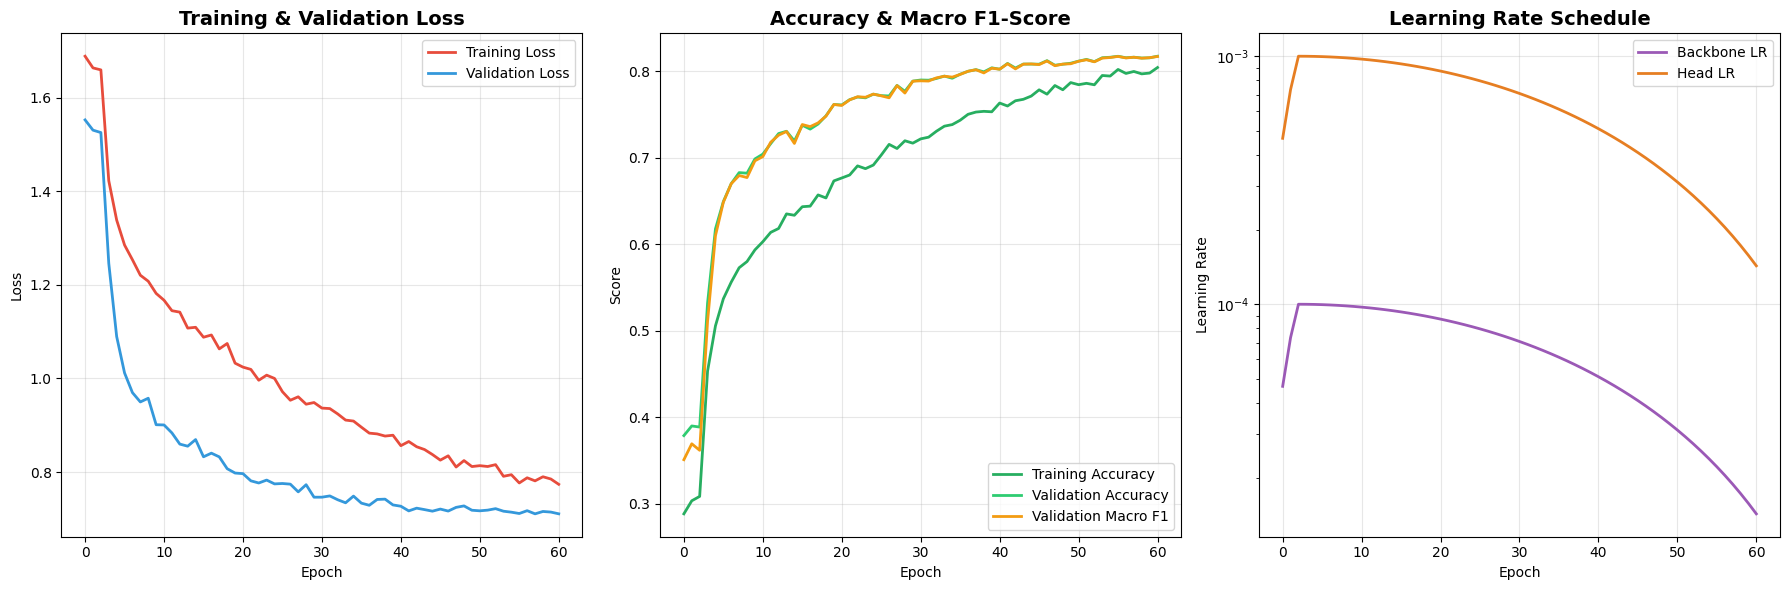

Training phase completed with enhanced monitoring and visualization!


In [9]:
# Enhanced Progressive Training Loop with Detailed Monitoring
print("\n" + "="*100)
print(f"STARTING ADVANCED TRAINING: {cfg.model_type.upper()} FOR EMOTION RECOGNITION")
print("="*100)
print(f"Model: {cfg.model_type} | Epochs: {cfg.epochs} | Batch Size: {cfg.batch_size}")
print(f"Progressive Strategy: {cfg.freeze_backbone_epochs} warmup -> full fine-tuning")
print(f"Monitoring Metric: {cfg.monitor} | Early Stopping Patience: {cfg.patience}")

# Initialize comprehensive training history tracking
training_history = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [],
    'val_macro_f1': [], 'lr_backbone': [], 'lr_head': [], 'epoch_times': []
}

# Initialize early stopping and best model tracking
early_stopper = EarlyStopper(patience=cfg.patience, mode='max')
best_validation_metric = -1.0
best_model_state = None
training_start_time = time.time()

# Stage 1: Progressive Unfreezing Setup
if cfg.freeze_backbone_epochs > 0:
    print("\nSTAGE 1: BACKBONE FREEZE PHASE")
    print("-" * 50)

    # Count parameters before freezing
    total_params_before = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Freeze backbone parameters, keep only classification head trainable
    frozen_params = 0
    trainable_params = 0

    for name, param in model.named_parameters():
        if any(head_name in name for head_name in ['fc', 'classifier', 'head', 'heads']):
            param.requires_grad = True
            trainable_params += param.numel()
        else:
            param.requires_grad = False
            frozen_params += param.numel()

    print(f"Frozen backbone parameters: {frozen_params:,} ({frozen_params/total_params_before*100:.1f}%)")
    print(f"Trainable head parameters: {trainable_params:,} ({trainable_params/total_params_before*100:.1f}%)")
    print(f"Strategy: Train only classification head for {cfg.freeze_backbone_epochs} epochs")
    print(f"Purpose: Prevent catastrophic forgetting of pre-trained features")
else:
    print("\nFULL TRAINING MODE: All parameters trainable from start")

print("\n" + "="*100)
print("EPOCH-BY-EPOCH TRAINING PROGRESS")
print("="*100)
print("Epoch | Phase    | Train L/A      | Val L/A/F1     | LR (bb/head)    | Time | Status")
print("-" * 100)

# Parse patterns for weight/grad printing
_weight_patterns = ['all'] if cfg.print_weight_modules.strip().lower() == 'all' else [p.strip() for p in cfg.print_weight_modules.split(',')]
_grad_patterns = ['all'] if cfg.print_grad_modules.strip().lower() == 'all' else [p.strip() for p in cfg.print_grad_modules.split(',')]

# Main Training Loop
for current_epoch in range(cfg.epochs):
    epoch_start_time = time.time()

    # Stage 2: Unfreeze backbone after warmup
    if current_epoch == cfg.freeze_backbone_epochs and cfg.freeze_backbone_epochs > 0:
        print("\n" + "-" * 50)
        print("STAGE 2: UNFREEZING BACKBONE - FULL FINE-TUNING BEGINS")
        print("-" * 50)

        # Unfreeze all parameters
        for param in model.parameters():
            param.requires_grad = True

        total_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"All {total_trainable:,} parameters now trainable")
        print(f"Backbone LR: {cfg.lr_backbone:.1e} | Head LR: {cfg.lr_head:.1e}")
        print(f"Strategy: Discriminative fine-tuning with different learning rates")
        print("-" * 50 + "\n")

    # Determine current training phase
    training_phase = "Warmup" if current_epoch < cfg.freeze_backbone_epochs else "Fine-tune"

    # Training Phase
    model.train()
    train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, device, criterion, scaler)

    # Optional: gradient stats just after backward/step are more meaningful, but we can inspect grads now.
    if cfg.print_grads and ((current_epoch + 1) % max(1, cfg.print_grads_every) == 0):
        print_grad_stats(model, _grad_patterns, max_lines=40,
                         header=f"\n[Epoch {current_epoch+1}] Gradient statistics (modules: {cfg.print_grad_modules})")

    # Apply EMA if enabled
    if ema:
        ema.apply(model)

    # Validation Phase
    model.eval()
    val_loss, val_accuracy, val_macro_f1, val_predictions, val_true_labels = evaluate(
        model, val_loader, device, criterion
    )

    # Learning Rate Scheduling
    scheduler.step()

    # Record Training History
    training_history['train_loss'].append(train_loss)
    training_history['train_acc'].append(train_accuracy)
    training_history['val_loss'].append(val_loss)
    training_history['val_acc'].append(val_accuracy)
    training_history['val_macro_f1'].append(val_macro_f1)

    # Capture learning rates for each parameter group
    if len(optimizer.param_groups) >= 2:
        training_history['lr_backbone'].append(optimizer.param_groups[0]['lr'])
        training_history['lr_head'].append(optimizer.param_groups[1]['lr'])
    else:
        current_lr = optimizer.param_groups[0]['lr']
        training_history['lr_backbone'].append(current_lr)
        training_history['lr_head'].append(current_lr)

    # Epoch timing
    epoch_duration = time.time() - epoch_start_time
    training_history['epoch_times'].append(epoch_duration)

    # Best Model Tracking and Checkpointing
    current_monitoring_metric = val_macro_f1 if cfg.monitor == 'macro_f1' else val_accuracy
    status_indicator = ""

    if current_monitoring_metric > best_validation_metric:
        best_validation_metric = current_monitoring_metric
        best_model_state = {
            'model_state_dict': model.state_dict(),
            'epoch': current_epoch,
            'validation_metric': best_validation_metric,
            'config': asdict(cfg),
            'training_history': training_history.copy()
        }
        torch.save(best_model_state, cfg.out_dir / 'best_model.pth')
        status_indicator = "NEW BEST"
    else:
        status_indicator = "Continue"

    # Detailed Epoch Progress Report
    lr_backbone_current = training_history['lr_backbone'][-1]
    lr_head_current = training_history['lr_head'][-1]

    print(f"{current_epoch+1:5d} | {training_phase:8s} | "
          f"{train_loss:.4f}/{train_accuracy:.3f} | "
          f"{val_loss:.4f}/{val_accuracy:.3f}/{val_macro_f1:.3f} | "
          f"{lr_backbone_current:.2e}/{lr_head_current:.2e} | "
          f"{epoch_duration:4.1f}s | {status_indicator}")

    # Optional: print weight stats
    if cfg.print_weights and ((current_epoch + 1) % max(1, cfg.print_weights_every) == 0):
        print_weight_stats(model, _weight_patterns, max_lines=40,
                           header=f"\n[Epoch {current_epoch+1}] Weight statistics (modules: {cfg.print_weight_modules})")

    # Early Stopping Check
    if early_stopper.step(current_monitoring_metric):
        total_training_time = time.time() - training_start_time
        print("\n" + "-" * 60)
        print(f"EARLY STOPPING TRIGGERED at Epoch {current_epoch + 1}")
        print(f"Total Training Time: {total_training_time/60:.1f} minutes")
        print(f"Best {cfg.monitor}: {best_validation_metric:.4f}")
        print("-" * 60)
        break

# Training Completion Summary
total_training_time = time.time() - training_start_time
print("\n" + "-" * 100)
print("TRAINING COMPLETED SUCCESSFULLY")
print("-" * 100)
print(f"Total Training Time: {total_training_time/60:.1f} minutes ({total_training_time/3600:.1f} hours)")
print(f"Total Epochs Completed: {len(training_history['train_loss'])}")
print(f"Best Validation {cfg.monitor}: {best_validation_metric:.4f}")
print(f"Average Time per Epoch: {np.mean(training_history['epoch_times']):.1f}s")
print(f"Best Model Saved: {cfg.out_dir / 'best_model.pth'}")
print("-" * 100 + "\n")

# Final weight/grad stats and optional dumps
if cfg.print_weights:
    print_weight_stats(model, _weight_patterns, max_lines=100,
                       header=f"\n[Final] Weight statistics (modules: {cfg.print_weight_modules})")
if cfg.print_grads:
    print_grad_stats(model, _grad_patterns, max_lines=100,
                     header=f"\n[Final] Gradient statistics (modules: {cfg.print_grad_modules})")

if cfg.save_final_weights_txt or cfg.save_final_grads_txt:
    out_w = cfg.out_dir / cfg.final_weights_filename
    out_g = cfg.out_dir / cfg.final_grads_filename
    try:
        if cfg.save_final_weights_txt:
            with open(out_w, 'w') as f:
                f.write(f"Final Weights Dump for model={cfg.model_type}\n")
                for name, p in model.named_parameters():
                    if not p.requires_grad:
                        continue
                    if 'all' not in _weight_patterns and not _module_matches(name, _weight_patterns):
                        continue
                    t = p.detach().float().cpu().numpy().ravel()
                    f.write(f"\n# {name} shape={tuple(p.shape)}\n")
                    max_values = 20000
                    if t.size > max_values:
                        f.write("[truncated]\n")
                        t = t[:max_values]
                    f.write(' '.join(map(lambda x: f"{x:.7g}", t)))
                    f.write("\n")
            print(f"Saved final weights to {out_w}")
        if cfg.save_final_grads_txt:
            with open(out_g, 'w') as f:
                f.write(f"Final Gradients Dump for model={cfg.model_type}\n")
                for name, p in model.named_parameters():
                    if p.grad is None:
                        continue
                    if 'all' not in _grad_patterns and not _module_matches(name, _grad_patterns):
                        continue
                    g = p.grad.detach().float().cpu().numpy().ravel()
                    f.write(f"\n# {name} grad shape={tuple(p.grad.shape)}\n")
                    max_values = 20000
                    if g.size > max_values:
                        f.write("[truncated]\n")
                        g = g[:max_values]
                    f.write(' '.join(map(lambda x: f"{x:.7g}", g)))
                    f.write("\n")
            print(f"Saved final gradients to {out_g}")
    except Exception as e:
        print(f"Saving final weights/grads failed: {e}")

# Compatibility
history = training_history
best_metric = best_validation_metric

print(f'Best {cfg.monitor} = {best_metric:.6f}')

# Training Curves Visualization
print("\nGenerating comprehensive training visualizations...")
plt.figure(figsize=(18, 6))

# Loss curves
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Training Loss', linewidth=2, color='#e74c3c')
plt.plot(history['val_loss'], label='Validation Loss', linewidth=2, color='#3498db')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy and F1 curves
plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Training Accuracy', linewidth=2, color='#27ae60')
plt.plot(history['val_acc'], label='Validation Accuracy', linewidth=2, color='#2ecc71')
plt.plot(history['val_macro_f1'], label='Validation Macro F1', linewidth=2, color='#f39c12')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Accuracy & Macro F1-Score', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate curves
plt.subplot(1, 3, 3)
plt.plot(history['lr_backbone'], label='Backbone LR', linewidth=2, color='#9b59b6')
plt.plot(history['lr_head'], label='Head LR', linewidth=2, color='#e67e22')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()

print("Training phase completed with enhanced monitoring and visualization!")

## Validation: Confusion Matrix + Classification Report (Best Checkpoint)
PyTorch 2.6 note: `torch.load` default `weights_only=True`. We explicitly set `weights_only=False` to load our dict with metadata safely (we created it in this notebook). Only do this for checkpoints you trust.

## Test Evaluation: Confusion Matrix + Classification Report

Validation (Best) Loss 0.7196 Acc 0.8130 MacroF1 0.8130

Validation Classification Report:
               precision    recall  f1-score   support

       angry     0.7663    0.8280    0.7959      2075
     fearful     0.7255    0.7706    0.7474      2075
       happy     0.9257    0.9123    0.9189      2075
     neutral     0.7946    0.7571    0.7754      2075
         sad     0.7957    0.7240    0.7581      2076
   surprised     0.8782    0.8863    0.8822      2075

    accuracy                         0.8130     12451
   macro avg     0.8143    0.8130    0.8130     12451
weighted avg     0.8143    0.8130    0.8130     12451



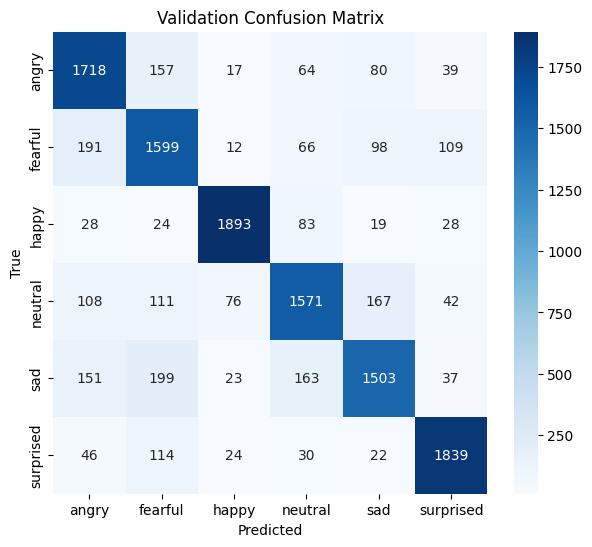

In [10]:
# Safe load (we created this checkpoint)
ckpt = torch.load(cfg.out_dir / 'best_model.pth', map_location=device, weights_only=False)
# Backward compatibility for state dict key
state_key = 'model'
if state_key not in ckpt:
    for k in ['model_state_dict', 'state_dict']:
        if k in ckpt:
            state_key = k
            break
model.load_state_dict(ckpt[state_key])
if ema:
    try:
        ema.apply(model)
    except Exception as e:
        print(f"EMA apply skipped: {e}")
model.eval()

val_loss, val_acc, val_macro_f1, val_preds, val_labels = evaluate(model, val_loader, device, criterion)
print(f'Validation (Best) Loss {val_loss:.4f} Acc {val_acc:.4f} MacroF1 {val_macro_f1:.4f}')
print('\nValidation Classification Report:\n', classification_report(val_labels, val_preds, target_names=CLASSES, digits=4))

cm_v = confusion_matrix(val_labels, val_preds, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(7,6))
sns.heatmap(cm_v, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Test Loss 0.7274 Acc 0.8120 MacroF1 0.8123

Test Classification Report:
               precision    recall  f1-score   support

       angry     0.7758    0.8270    0.8006      2075
     fearful     0.7193    0.7778    0.7474      2075
       happy     0.9350    0.9070    0.9208      2076
     neutral     0.7871    0.7696    0.7783      2075
         sad     0.8042    0.7263    0.7632      2075
   surprised     0.8628    0.8641    0.8635      2075

    accuracy                         0.8120     12451
   macro avg     0.8140    0.8120    0.8123     12451
weighted avg     0.8140    0.8120    0.8123     12451



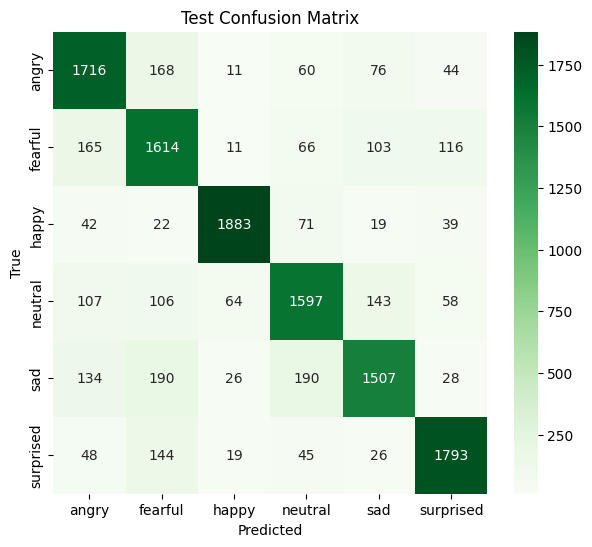

In [11]:
test_loss, test_acc, test_macro_f1, test_preds, test_labels = evaluate(model, test_loader, device, criterion)
print(f'Test Loss {test_loss:.4f} Acc {test_acc:.4f} MacroF1 {test_macro_f1:.4f}')
print('\nTest Classification Report:\n', classification_report(test_labels, test_preds, target_names=CLASSES, digits=4))

cm_t = confusion_matrix(test_labels, test_preds, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(7,6))
sns.heatmap(cm_t, annot=True, fmt='d', cmap='Greens', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Test Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

## Grad-CAM / Grad-CAM++
Updated for current `pytorch-grad-cam` API (no `use_cuda` arg).


Grad-CAM visualizations:


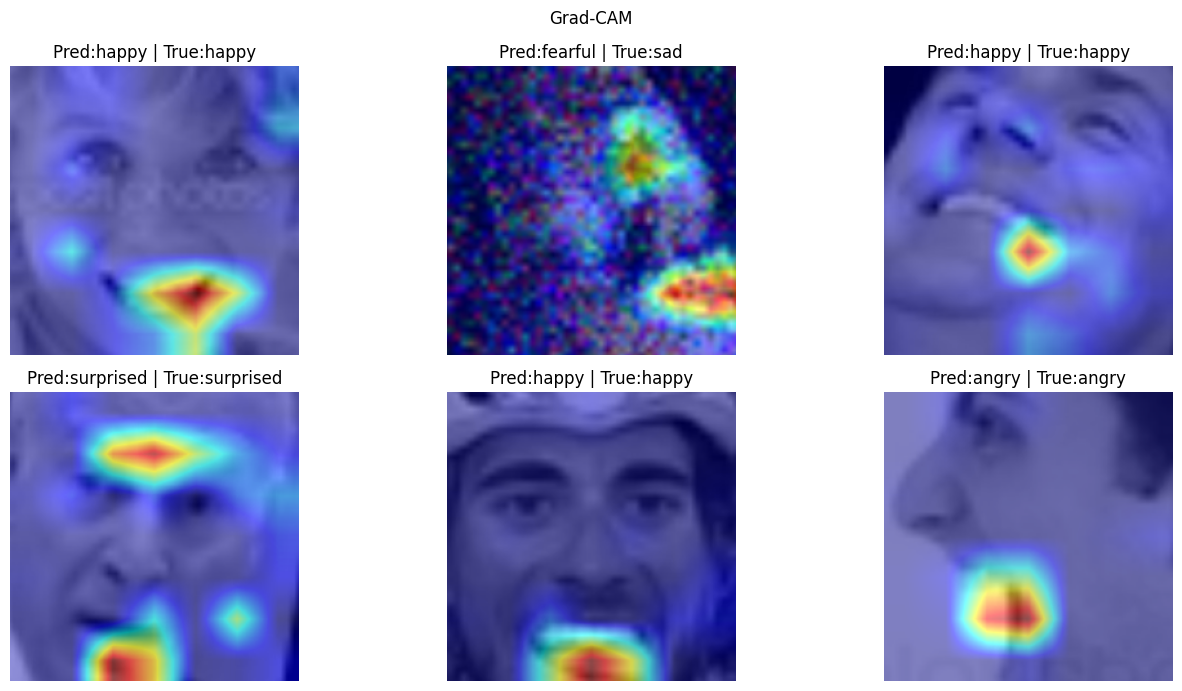


Grad-CAM++ visualizations:


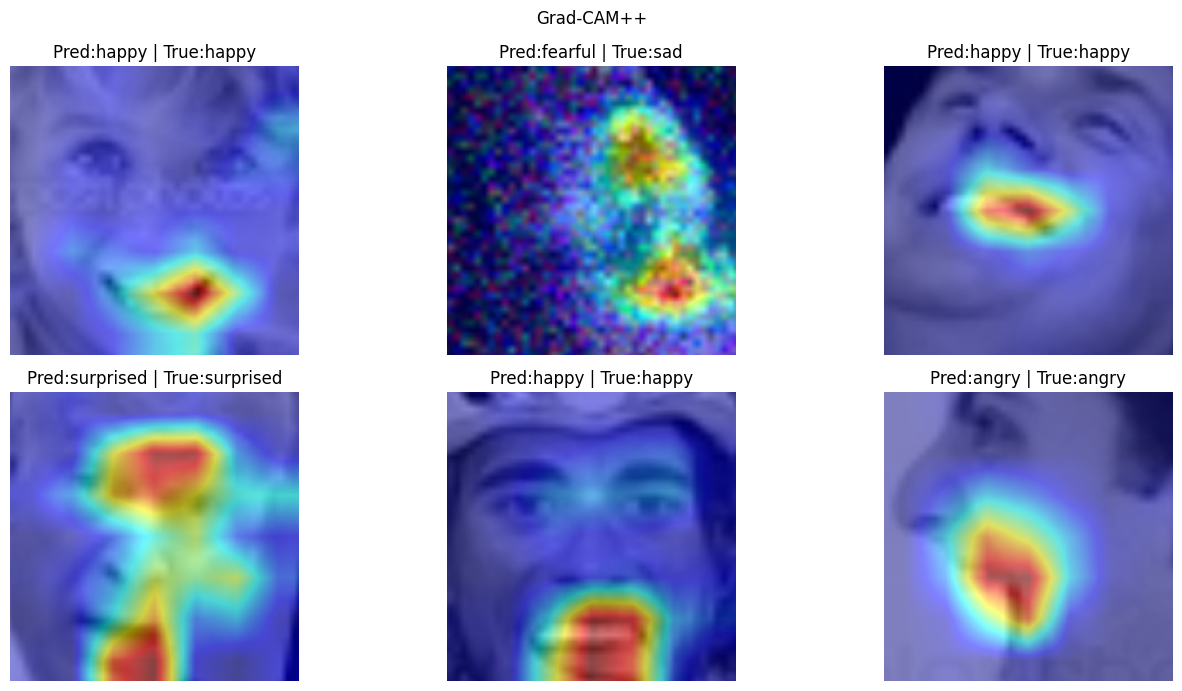

In [12]:
def tensor_to_rgb(img_t: torch.Tensor):
    # img_t: 1x3xHxW normalized tensor
    x = img_t.squeeze(0).detach().cpu().numpy()
    x = np.transpose(x, (1,2,0))
    x = (x * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN))
    x = np.clip(x, 0, 1)
    return x

def select_target_layers_for_cam(model):
    if cfg.model_type == 'resnet50':
        return [model.layer4[-1]]
    elif cfg.model_type.startswith('vit') and hasattr(model, 'blocks'):
        return [model.blocks[-1].norm1] if hasattr(model.blocks[-1], 'norm1') else [model.blocks[-1]]
    else:
        # try to find last conv
        for name, module in reversed(list(model.named_modules())):
            if isinstance(module, nn.Conv2d): return [module]
        raise ValueError('No suitable CAM layer found.')

if cfg.run_gradcam or cfg.run_gradcam_pp:
    imgs_vis, labels_vis = [], []
    for i in range(min(6, len(test_dataset))):
        img, lab, _ = test_dataset[i]
        imgs_vis.append(img); labels_vis.append(lab)
    imgs_vis_t = torch.stack(imgs_vis).to(device)
    target_layers = select_target_layers_for_cam(model)

    model.eval()
    with torch.no_grad():
        logits = model(imgs_vis_t)
        preds = logits.argmax(1).cpu().numpy()

    cam_methods = []
    if cfg.run_gradcam: cam_methods.append(('Grad-CAM', GradCAM))
    if cfg.run_gradcam_pp: cam_methods.append(('Grad-CAM++', GradCAMPlusPlus))

    for cam_name, CamClass in cam_methods:
        cam = CamClass(model=model, target_layers=target_layers)
        grayscale_cam = cam(input_tensor=imgs_vis_t)  # [N, H, W]
        print(f'\n{cam_name} visualizations:')
        plt.figure(figsize=(14,7))
        for i in range(len(imgs_vis)):
            rgb = tensor_to_rgb(imgs_vis[i].unsqueeze(0))
            grad_cam_map = grayscale_cam[i]
            vis = show_cam_on_image(rgb, grad_cam_map, use_rgb=True)
            plt.subplot(2, 3, i+1)
            plt.imshow(vis)
            plt.axis('off')
            plt.title(f'Pred:{CLASSES[preds[i]]} | True:{CLASSES[labels_vis[i]]}')
        plt.suptitle(cam_name)
        plt.tight_layout(); plt.show()

## SHAP (DeepExplainer)
We use a small background set for speed. DeepExplainer supports PyTorch models directly.

### Reload Best Checkpoint & Evaluate
This cell safely rebuilds the model if the kernel was restarted (so `model` no longer exists) and then loads `best_model.pth`.

Recovery steps performed:
1. Reconstruct architecture (uses `cfg.model_type`, defaults to `resnet50`).
2. Locate the correct state dict key among common names (model / model_state_dict / state_dict) or heuristically.
3. Load weights with `strict=False` (prints any missing/unexpected keys).
4. Apply EMA weights if the EMA helper still exists.
5. Run evaluation and show classification report + confusion matrix.

If you see a failure about undefined `cfg`, `CLASSES`, or `evaluate`, re-run the earlier setup/training cells first.

In [13]:
def disable_inplace_ops(module: nn.Module) -> int:
    """Recursively switch all modules that support `inplace` to `inplace=False`.
    Returns the number of modules changed.
    """
    changed = 0
    for _name, child in module.named_children():
        changed += disable_inplace_ops(child)
    if hasattr(module, "inplace"):
        try:
            if getattr(module, "inplace"):
                setattr(module, "inplace", False)
                changed += 1
        except Exception:
            pass
    return changed

# Apply the patch to the current model if available
if 'model' in globals() and isinstance(model, nn.Module):
    num_changed = disable_inplace_ops(model)
    print(f"Disabled inplace=True on {num_changed} submodules")
else:
    print("Note: model not found yet. Define your model, then run: disable_inplace_ops(model)")

# Ensure inputs are fresh tensors that require grad for SHAP

def _prep_for_shap(x):
    if isinstance(x, torch.Tensor):
        return x.clone().detach().requires_grad_(True)
    return x

if 'bg_tensors' in globals():
    if isinstance(bg_tensors, (list, tuple)):
        bg_tensors = [ _prep_for_shap(t) for t in bg_tensors ]
    else:
        bg_tensors = _prep_for_shap(bg_tensors)
else:
    print("Note: bg_tensors not found in scope yet.")

if 'test_tensors' in globals():
    if isinstance(test_tensors, (list, tuple)):
        test_tensors = [ _prep_for_shap(t) for t in test_tensors ]
    else:
        test_tensors = _prep_for_shap(test_tensors)
else:
    print("Note: test_tensors not found in scope yet.")

# Put model in eval and ensure gradients are enabled for SHAP attributions
if 'model' in globals() and isinstance(model, nn.Module):
    model.eval()

torch.set_grad_enabled(True)
print("Setup done. Re-run your SHAP cell next.")

Disabled inplace=True on 17 submodules
Note: bg_tensors not found in scope yet.
Note: test_tensors not found in scope yet.
Setup done. Re-run your SHAP cell next.


## LIME (small subset)
Model-agnostic local explanations on a few samples.

Running LIME (small subset for speed)...


  0%|          | 0/600 [00:00<?, ?it/s]

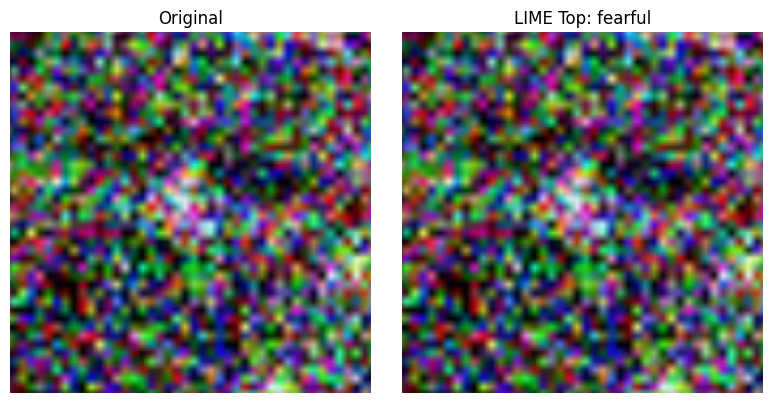

  0%|          | 0/600 [00:00<?, ?it/s]

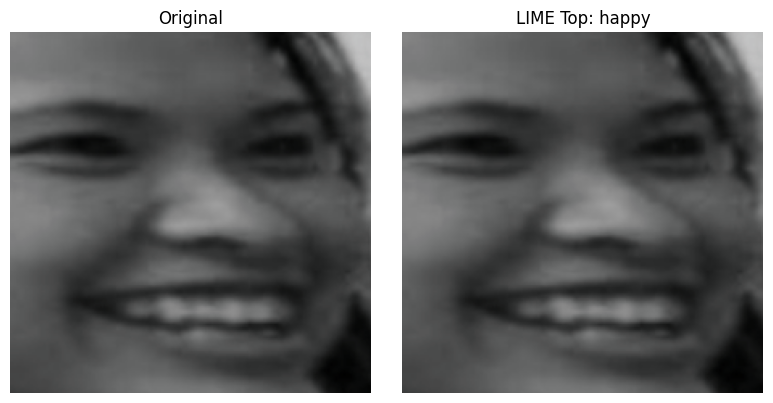

  0%|          | 0/600 [00:00<?, ?it/s]

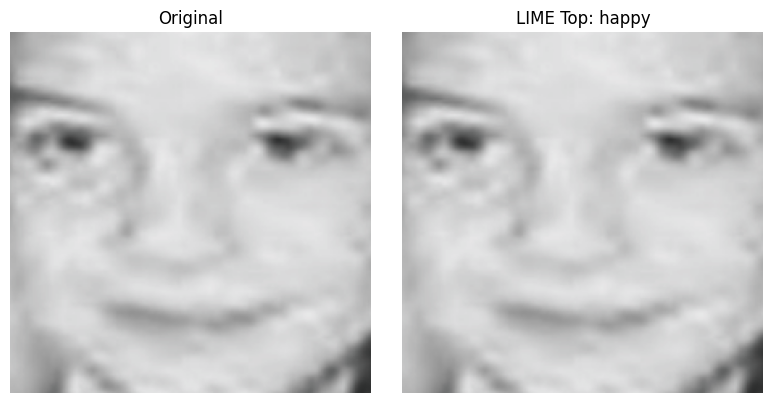

  0%|          | 0/600 [00:00<?, ?it/s]

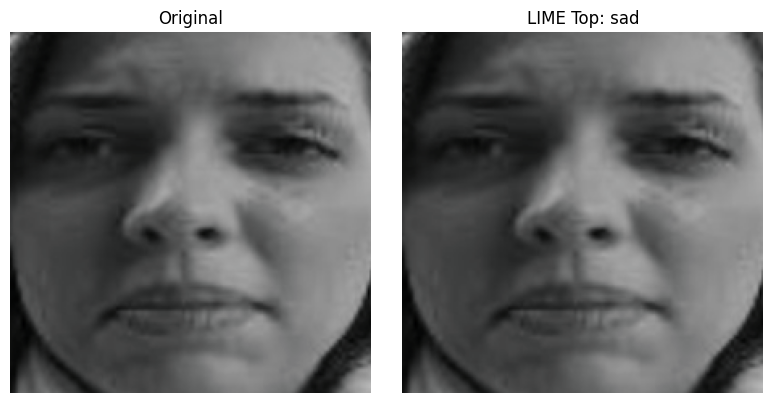

In [14]:
if cfg.run_lime:
    print('Running LIME (small subset for speed)...')
    explainer = lime_image.LimeImageExplainer()

    def predict_fn_for_explain(x: np.ndarray) -> np.ndarray:
        # x: N,H,W,3 uint8 or float [0..255]
        xs = []
        for i in range(x.shape[0]):
            img = x[i].astype(np.float32)
            if img.max() > 1.5: img = img / 255.0
            img_t = torch.tensor(np.transpose(img, (2,0,1)), dtype=torch.float32)
            # normalize
            for c in range(3):
                img_t[c] = (img_t[c] - IMAGENET_MEAN[c]) / IMAGENET_STD[c]
            xs.append(img_t)
        xs = torch.stack(xs).to(device)
        with torch.no_grad():
            logits = model(xs)
            probs = F.softmax(logits, dim=1).cpu().numpy()
        return probs

    lime_idx = np.random.choice(len(test_dataset), size=min(4, len(test_dataset)), replace=False)
    for idx in lime_idx:
        img_t, _, _ = test_dataset[idx]
        img = np.transpose(img_t.numpy(), (1,2,0))
        img_rgb = (np.clip((img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)), 0, 1) * 255).astype(np.uint8)
        explanation = explainer.explain_instance(
            image=img_rgb,
            classifier_fn=predict_fn_for_explain,
            top_labels=1,
            hide_color=0,
            num_samples=600
        )
        top = explanation.top_labels[0]
        temp, mask = explanation.get_image_and_mask(label=top, positive_only=True, num_features=6, hide_rest=False)
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1); plt.imshow(img_rgb); plt.axis('off'); plt.title('Original')
        plt.subplot(1,2,2); plt.imshow(temp); plt.axis('off'); plt.title(f'LIME Top: {CLASSES[top]}')
        plt.tight_layout(); plt.show()

## ONNX Export + Runtime Check

### ONNX export fix and modern exporter usage
We patch in-place ops (again if needed), detach hooks, and use the modern `dynamo=True` exporter. If unsupported ops remain, we fall back to opset 11–13 and disable constant folding to avoid in-place rewrites.

In [15]:
import torch
import torch.nn as nn
import os
from typing import List, Tuple, Optional

# 1) Reuse the disable_inplace_ops utility if present, otherwise define it
def _disable_inplace_ops_if_any(m: nn.Module) -> int:
    def _disable(module: nn.Module) -> int:
        changed = 0
        for _n, ch in module.named_children():
            changed += _disable(ch)
        if hasattr(module, 'inplace') and getattr(module, 'inplace') is True:
            try:
                module.inplace = False
                changed += 1
            except Exception:
                pass
        return changed
    return _disable(m) if isinstance(m, nn.Module) else 0

# 2) Optional: remove hooks that may install custom backward Functions
def _remove_all_hooks(m: nn.Module) -> int:
    removed = 0
    for mod in m.modules():
        if hasattr(mod, '_forward_hooks') and mod._forward_hooks:
            mod._forward_hooks.clear()
            removed += 1
        if hasattr(mod, '_backward_hooks') and mod._backward_hooks:
            mod._backward_hooks.clear()
            removed += 1
        if hasattr(mod, '_forward_pre_hooks') and mod._forward_pre_hooks:
            mod._forward_pre_hooks.clear()
            removed += 1
    return removed

# 3) Define a safe wrapper module that clones outputs to avoid view+inplace clashes
class CloneOutputWrapper(nn.Module):
    def __init__(self, base: nn.Module):
        super().__init__()
        self.base = base
    def forward(self, x):
        y = self.base(x)
        # Clone to ensure no view is returned directly through custom autograd paths
        return y.clone() if isinstance(y, torch.Tensor) else y

# 4) ONNX export helper using modern exporter (dynamo=True), with fallbacks
def export_onnx_safe(
    model: nn.Module,
    example: torch.Tensor,
    out_path: str = "models/model_updated.onnx",
    opset_list: List[int] = [17, 16, 15, 13, 11],
    dynamic: bool = True,
    do_clone_wrapper: bool = True,
    disable_const_folding_first: bool = True,
    verbose: bool = False,
    input_names: Optional[List[str]] = None,
    output_names: Optional[List[str]] = None,
    dynamic_axes: Optional[dict] = None,
    ) -> Tuple[bool, Optional[str]]:
    os.makedirs(os.path.dirname(out_path) or '.', exist_ok=True)
    model.eval()
    with torch.inference_mode(False):  # allow grads if exporter needs autograd tracing
        # Prepare model
        changed = _disable_inplace_ops_if_any(model)
        removed = _remove_all_hooks(model)
        if verbose:
            print(f"Disabled inplace on {changed} modules; removed hooks from {removed} modules")
        to_export = CloneOutputWrapper(model) if do_clone_wrapper else model
        # Default names/axes
        if input_names is None:
            input_names = ["input"]
        if output_names is None:
            output_names = ["output"]
        if dynamic and dynamic_axes is None:
            dynamic_axes = {"input": {0: "batch"}, "output": {0: "batch"}}
        # Try modern exporter first, various opsets and settings
        export_errors = []
        for opset in opset_list:
            for do_fold in ([False, True] if disable_const_folding_first else [True, False]):
                try:
                    torch.onnx.export(
                        to_export,
                        example,
                        out_path,
                        export_params=True,
                        opset_version=opset,
                        do_constant_folding=do_fold,
                        input_names=input_names,
                        output_names=output_names,
                        dynamic_axes=dynamic_axes,
                        training=torch.onnx.TrainingMode.EVAL,
                        dynamo=True,  # new exporter path
                        verbose=verbose,
                    )
                    if verbose:
                        print(f"Exported with opset={opset}, const_fold={do_fold}")
                    return True, out_path
                except Exception as e:
                    msg = f"opset={opset}, const_fold={do_fold}: {e}"
                    export_errors.append(msg)
        print("ONNX export failed after trying multiple settings. First error:")
        if export_errors:
            print(export_errors[0])
        return False, None

# 5) Run if a `model` and an example input are available in the notebook
if 'model' in globals():
    # Try to infer an example input from bg_tensors/test_tensors if available
    example_input = None
    if 'bg_tensors' in globals():
        example_input = bg_tensors[0] if isinstance(bg_tensors, (list, tuple)) else bg_tensors
    if example_input is None and 'test_tensors' in globals():
        example_input = test_tensors[0] if isinstance(test_tensors, (list, tuple)) else test_tensors
    if example_input is None:
        print("Provide an example input tensor: example_input = torch.randn(1,3,H,W)")
    else:
        if not isinstance(example_input, torch.Tensor):
            print("Example input is not a Tensor. Please provide a Tensor.")
        else:
            # Ensure float and on CPU
            example_input = example_input.detach().clone().to(torch.float32).cpu()
            ok, path = export_onnx_safe(
                model, example_input, out_path="models/model_fixed.onnx", verbose=True
            )
            if ok:
                print(f"ONNX export succeeded: {path}")
            else:
                print("ONNX export still failed. See above errors. Consider simplifying the model or removing unsupported ops.")
else:
    print("Model not found. Define your model before running the ONNX export cell.")

Provide an example input tensor: example_input = torch.randn(1,3,H,W)


## Publish best model to Hugging Face
This will read your `HF_TOKEN` from the project `.env`, log in to Hugging Face, create the repo if needed, and upload the best model artifacts from the `models/` folder.

In [16]:
# Install requirements for programmatic upload if missing
import sys, subprocess, pkgutil
def _pip_install(pkg):
    print(f"Installing {pkg}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
for pkg in ["huggingface_hub", "python-dotenv"]:
    if pkg not in {p.name for p in pkgutil.iter_modules()}:
        _pip_install(pkg)
print("Ready to publish to Hugging Face.")

Installing python-dotenv...
Ready to publish to Hugging Face.


In [20]:
# Login using token from .env and upload `models/` to repo `hirumunasinghe/emotion_face_detector`
import os, json, pathlib, shutil
from huggingface_hub import login, HfApi, HfFolder, create_repo, upload_folder, upload_file
# Use Colab's userdata to access secrets
from google.colab import userdata

# 1) Load token from Colab Secrets Manager
token = userdata.get("HF_TOKEN")
if not token:
    raise RuntimeError("HF_TOKEN not found in Colab Secrets. Please add it there.")

# 2) Login (stores token locally for git and API)
# Using token=token directly with HfApi is also an option if local storage is not desired
login(token=token)
# HfFolder.save_token(token) # Saving to HfFolder is often not needed with direct token use

api = HfApi(token=token) # Use the token directly with HfApi

# 3) Define repo info and local paths
repo_id = "hirumunasinghe/emotion_face_detector"
model_dir = pathlib.Path("/content/ann-visual-emotion/models")
assert model_dir.exists(), f"Models directory not found: {model_dir}"

# Select best artifacts to include
include_files = []
for name in ["best_model.pth", "model.onnx", "label_map.json"]:
    p = model_dir / name
    if p.exists():
        include_files.append(str(p))
if not include_files:
    raise FileNotFoundError("No model files found (best_model.pth, model.onnx, label_map.json)")

# 4) Ensure repo exists (public)
create_repo(repo_id=repo_id, private=False, exist_ok=True)

# 5) Upload all files from models/ (filters to known files above)
# Option A: upload selected files to the root of the repo
for fp in include_files:
    path_in_repo = os.path.basename(fp)
    res = upload_file(
        path_or_fileobj=fp,
        path_in_repo=path_in_repo,
        repo_id=repo_id,
        repo_type="model",
    )
    print(f"Uploaded: {path_in_repo}")

# 6) Optionally push extra metadata: a README.md
readme_content = (
    "# Emotion Face Detector\n\n"
    "This repository contains the best model artifacts for the emotion face detector.\n\n"
    "- best_model.pth: PyTorch weights\n"
    "- model.onnx: Exported ONNX model\n"
    "- label_map.json: Class id to label mapping\n\n"
    "Uploaded from ann-visual-emotion.\n"
)
tmp_readme = model_dir / "README.md"
tmp_readme.write_text(readme_content)
upload_file(
    path_or_fileobj=str(tmp_readme),
    path_in_repo="README.md",
    repo_id=repo_id,
    repo_type="model",
)
print("Published README.md")
print(f"Done. View your repo at: https://huggingface.co/{repo_id}")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ion/models/best_model.pth:   1%|          |  555kB / 98.6MB            

Uploaded: best_model.pth


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...emotion/models/model.onnx:  36%|###5      | 33.5MB / 94.0MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Uploaded: model.onnx


No files have been modified since last commit. Skipping to prevent empty commit.


Uploaded: label_map.json


/usr/local/lib/python3.12/dist-packages/huggingface_hub/hf_api.py:9717: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


Published README.md
Done. View your repo at: https://huggingface.co/hirumunasinghe/emotion_face_detector


In [32]:
# Update Hugging Face model card with YAML metadata to remove the warning
import os, json, pathlib
from huggingface_hub import HfApi, upload_file, HfFolder
from dotenv import load_dotenv, find_dotenv
from google.colab import userdata # Import userdata for Colab Secrets

# Load token from Colab Secrets Manager
token = userdata.get("HF_TOKEN")
api = HfApi(token=token) if token else HfApi() # Use token directly with HfApi

repo_id = "hirumunasinghe/emotion_face_detector"
# Correct the model_dir path to where the models were actually saved
model_dir = pathlib.Path("/content/ann-visual-emotion/models")

labels_list = None
try:
    with open(model_dir / "label_map.json", "r") as f:
        m = json.load(f)
        # Assuming label_map.json contains a dict or a list of labels
        if isinstance(m, dict):
            # Extract labels from a dictionary mapping (assuming values are labels)
            labels_list = list(m.keys())
        elif isinstance(m, list):
            # Use the list directly if it's already a list of labels
            labels_list = m
        # Ensure labels are strings if they were integers (from id mapping)
        labels_list = [str(lbl) for lbl in labels_list]

except FileNotFoundError:
    print(f"Warning: label_map.json not found at {model_dir / 'label_map.json'}. Cannot add labels to model card.")
    pass
except Exception as e:
    print(f"Warning: Could not load or parse label_map.json: {e}")
    pass


labels_yaml = ""
if labels_list:
    labels_yaml = "labels:\n" + "\n".join([f"- {lbl}" for lbl in labels_list]) + "\n"

# Use an f-string for labels_yaml only; escape braces in code block with doubled {{ }}
# Use an f-string for labels_yaml only; escape braces in code block with doubled {{ }}
readme_content = f"""---
language:
- en
license: mit
tags:
- computer-vision
- image-classification
- emotions
- pytorch
pipeline_tag: image-classification
library_name: pytorch
{labels_yaml}model-index:
- name: Emotion Face Detector
  results: []
---

# Emotion Face Detector

This repository contains the best model artifacts for an image-based facial emotion classifier.

Artifacts included:
- `best_model.pth`: PyTorch weights
- `model.onnx`: Exported ONNX model
- `label_map.json`: Class id to label mapping

## Usage (ONNX Runtime)
"""

In [35]:
# This cell will write the README.md file with the YAML metadata and upload it to Hugging Face
# It uses variables defined in the previous cell (Psk049NifNVg) like `readme_content` and `model_dir`

# Ensure the model_dir exists (defined in the previous cell)
if 'model_dir' not in locals() or not model_dir.exists():
    print("Error: model_dir not found or does not exist. Please run the previous cell first.")
else:
    readme_path = model_dir / "README.md"

    try:
        # Write the README content to the file
        readme_path.write_text(readme_content)
        print(f"Created README.md at {readme_path}")

        # Upload the README.md to the Hugging Face repository
        # Requires `api` and `repo_id` from the previous cell
        if 'api' in locals() and 'repo_id' in locals():
            upload_file(
                path_or_fileobj=str(readme_path),
                path_in_repo="README.md",
                repo_id=repo_id,
                repo_type="model",
            )
            print(f"Uploaded README.md to https://huggingface.co/{repo_id}")
        else:
            print("Error: Hugging Face api or repo_id not found. Please run the previous cell first.")

    except Exception as e:
        print(f"An error occurred while creating or uploading the README: {e}")

Created README.md at /content/ann-visual-emotion/models/README.md
Uploaded README.md to https://huggingface.co/hirumunasinghe/emotion_face_detector
